## ✈️ *TravelTide* - Customer Segmentation Project
---
### Modeling - Segmentation

### 1. Introduction

This notebook covers the Modeling (Segmentation) phase of the TravelTide project.  
It combines a business-driven, rule-based framework—built on four interpretable behavioral dimensions (Value, Risk, Complexity, Engagement), with a data-driven clustering analysis used for validation and discovery. 

The rule-based layer defines perk eligibility and assigns one perk per user through a priority logic, while clustering explores whether similar structures emerge from user behavior without business thresholds or composite scores. 

The outcome is a transparent, action-oriented segmentation baseline that feeds directly into the final evaluation and recommendations stage.


**Author**: Maria Petralia  
**Project**: TravelTide - Customer Segmentation & Perk Strategy  
**Context**: MasterSchool - Data Science Program  
**Date**: Feb 2026


### 2. Setup

###### Load Libraries

In [0]:
# Load Libraries

# Data Handling & Analysis
# ---------------------------------------------
import pandas as pd
import numpy as np

# Visualization
# ---------------------------------------------
import matplotlib.pyplot as plt     # Plotting
import seaborn as sns               # Statistical visualizations

# Data Preprocessing
# ---------------------------------------------
from sklearn.preprocessing import StandardScaler  # Feature scaling

# Dimensionality Reduction
# ---------------------------------------------
from sklearn.decomposition import PCA  # Principal Component Analysis

# Clustering Algorithms
# ---------------------------------------------
from sklearn.cluster import KMeans                   # K-Means clustering

# Hierarchical clustering tools
# ---------------------------------------------
from scipy.cluster.hierarchy import dendrogram, linkage  # Dendrogram construction

# Metrics for Clustering Evaluation
# ---------------------------------------------
from sklearn.metrics import silhouette_score  # Evaluation metric

# Rendering HTML
# ---------------------------------------------
from IPython.display import display, HTML  # Enhanced output formatting

###### Set Global Plotting Style

In [0]:
# Global Plotting Style 
# ---------------------------------------------

# Base seaborn style
sns.set(style="ticks") 

# TravelTide visual identity (global palette) 
travel_palette = [
    "#176C8C",  # Blue 1 - mid ocean
    "#7E6A9F",  # Purple 1 - lavender
    "#6BBBD9",  # Blue 3 - light sky
    "#D0F3FF",  # Blue 4 - light blue
    "#E8C9A1",  # Sand 1 - warm sand
    "#F1D7B5",  # Sand 2 - soft beige
    "#F4B998",  # Sand 3 - peach sand
    "#DD1111",  # Red 1 - bright red
]

### 3. Dataset Overview

#### 3.1 Load User-Level Dataset Segmentation 

In [0]:
# Segmentation-ready dataset (semantic NaNs preserved)
csv_path = "../data/intermediate/user_level_for_segmentation.csv"
seg_df = pd.read_csv(csv_path, low_memory=False)

print("Segmentation-ready user-level dataset loaded.")

# Quick preview
seg_df.head()

Segmentation-ready user-level dataset loaded.


,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,last_session_date,last_booking_date,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,total_flight_spend,total_hotel_spend,total_spend,cancelled_trips,booking_rate,cancellation_rate,conversion_rate,avg_session_duration,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days,age,avg_spend_per_trip,has_cancellation,R_days,R_score,F_score,M_score,RFM_score,RFM_segment,RFM_persona,CLTV_3m,has_flight_history,has_hotel_history
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,2023-07-14 12:36:00,2023-07-14 12:36:00,190,8,2,2,0.00,3802.0,3802.00,0,0.250,0.0,1.0,1.277083,10.250,NaN,NaN,10.0,18.0,NaN,1.5,NaN,NaN,NaN,64,1901.000,False,15.0,5,2,4,11,5-2-4,Big Spenders,1800.947368,False,True
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,2023-05-28 17:28:00,2023-04-10 21:13:00,138,8,2,2,864.09,230.0,1094.09,0,0.250,0.0,1.0,1.129167,9.125,1453.666128,1536.436758,1.0,1.0,1.5,1.5,0.5,2.5,3.0,51,547.045,False,109.0,2,2,2,6,2-2-2,Hibernating,713.536957,True,True
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,2023-07-18 09:35:00,2023-06-17 19:42:00,178,8,2,2,189.91,2452.0,2641.91,0,0.250,0.0,1.0,2.037500,16.375,965.340568,965.340568,4.5,5.0,1.0,1.5,0.0,5.0,5.0,50,1320.955,False,42.0,4,2,3,9,4-2-3,Potential Loyalists,1335.797191,True,True
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,2023-06-22 13:27:00,2023-06-22 13:27:00,154,8,5,5,1242.66,2798.0,4040.66,0,0.625,0.0,1.0,1.962500,15.750,1321.684183,4003.264513,4.4,8.0,1.0,1.0,0.4,5.8,9.0,42,808.132,False,37.0,4,5,4,13,4-5-4,Champions,2361.424675,True,True
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,2023-07-27 09:43:48,2023-06-06 09:41:00,197,8,1,2,27804.12,8514.0,36318.12,1,0.125,1.0,0.0,12.648584,30.000,13402.323077,13402.323077,11.0,11.0,6.0,3.0,5.0,14.0,14.0,44,36318.120,True,53.0,4,1,5,10,4-1-5,Big Spenders,16592.034518,True,True


**Note**: This dataset represents the final user-level view after feature engineering and validation, and is used as the baseline for all downstream analyses.

#### 3.2 Structural and Data Quality Checks

In [0]:
# Dataframe structure
seg_df.shape

(5998, 47)

In [0]:
# Dataframe information
seg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 5998 non-null   int64  
 1   gender                  5998 non-null   object 
 2   married                 5998 non-null   bool   
 3   birthdate               5998 non-null   object 
 4   has_children            5998 non-null   bool   
 5   home_country            5998 non-null   object 
 6   home_city               5998 non-null   object 
 7   home_airport            5998 non-null   object 
 8   sign_up_date            5998 non-null   object 
 9   first_session_date      5998 non-null   object 
 10  last_session_date       5998 non-null   object 
 11  last_booking_date       5532 non-null   object 
 12  tenure_days             5998 non-null   int64  
 13  n_sessions              5998 non-null   int64  
 14  n_booking_sessions      5998 non-null   

In [0]:
# Missingness overview
seg_df.isna().mean().sort_values(ascending=False).head(15)

avg_distance_km           0.139213
max_distance_km           0.139213
avg_seats                 0.139213
avg_checked_bags          0.139213
avg_trip_duration_days    0.139213
max_trip_duration_days    0.139213
avg_nights                0.101867
max_nights                0.101867
avg_rooms                 0.101867
avg_spend_per_trip        0.077693
last_booking_date         0.077693
age                       0.000000
user_id                   0.000000
avg_page_clicks           0.000000
R_days                    0.000000
dtype: float64

In [0]:
# Descriptive statistics
seg_df.describe()

,user_id,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,total_flight_spend,total_hotel_spend,total_spend,cancelled_trips,booking_rate,cancellation_rate,conversion_rate,avg_session_duration,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days,age,avg_spend_per_trip,R_days,R_score,F_score,M_score,RFM_score,CLTV_3m
count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5163.000000,5163.000000,5387.000000,5387.000000,5163.000000,5387.000000,5163.000000,5163.000000,5163.000000,5998.000000,5532.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000
mean,545440.695565,141.154051,8.167222,2.646382,2.747249,1238.984038,2256.626709,3495.610747,0.100867,0.324685,0.044899,0.955101,3.105022,17.533944,2357.695394,3163.372121,4.476690,6.592909,1.216935,1.198560,0.600262,5.293552,7.148363,40.782761,1409.675483,107.635879,2.983328,2.687396,3.000000,8.670724,2297.659260
std,64924.749760,32.425509,0.503328,1.508963,1.559387,1778.040875,2473.022440,3356.455568,0.308832,0.185207,0.159972,0.159972,3.998719,8.726611,1697.848379,2188.559225,2.846284,4.505767,0.447324,0.353712,0.512556,2.735723,3.931917,12.055621,1575.205970,108.666296,1.406193,1.310981,1.414449,3.455539,2384.171742
min,23557.000000,23.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.525000,4.125000,27.440552,27.440552,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,16.000000,9.270000,8.000000,1.000000,1.000000,1.000000,3.000000,0.000000
25%,517152.000000,121.000000,8.000000,2.000000,2.000000,361.880000,646.250000,1361.992500,0.000000,0.222222,0.000000,1.000000,1.542593,12.375000,1478.536877,2080.167296,2.666667,4.000000,1.000000,1.000000,0.250000,3.750000,5.000000,34.000000,723.733167,36.000000,2.000000,2.000000,2.000000,6.000000,901.713622
50%,540542.000000,145.000000,8.000000,3.000000,3.000000,868.550000,1580.000000,2718.255000,0.000000,0.333333,0.000000,1.000000,1.935417,15.500000,2032.712792,2897.015133,3.750000,5.000000,1.000000,1.000000,0.500000,4.666667,6.000000,41.000000,1029.142333,79.000000,3.000000,3.000000,3.000000,9.000000,1778.652123
75%,574146.000000,166.000000,8.000000,4.000000,4.000000,1519.515000,3011.500000,4680.050000,0.000000,0.500000,0.000000,1.000000,2.449537,19.571429,2748.275850,3814.927468,5.500000,9.000000,1.333333,1.333333,1.000000,6.000000,9.000000,48.000000,1536.672500,133.000000,4.000000,4.000000,4.000000,11.000000,3004.763157
max,844489.000000,430.000000,12.000000,8.000000,9.000000,29185.040000,29047.000000,43896.890000,2.000000,1.000000,1.000000,1.000000,33.752083,109.125000,15935.659875,17404.917859,30.000000,43.000000,6.000000,4.000000,5.666667,27.000000,36.000000,88.000000,37247.040000,440.000000,5.000000,5.000000,5.000000,15.000000,39811.989130


In [0]:
# Check negative values on CLTV 
(seg_df["CLTV_3m"] < 0).sum()

np.int64(0)

###### Sanity Checks

In [0]:
# Check missing values on CLTV
seg_df["CLTV_3m"].isna().sum()

np.int64(0)

In [0]:
# Check missing values on cancellation_rate
seg_df["cancellation_rate"].isna().sum()

np.int64(0)

In [0]:
# Check negative values on booking_rate
(seg_df["booking_rate"] > 1).sum()

np.int64(0)

**Note**: All structural checks and data quality validations are performed on the segmentation-ready dataset, which preserves the original semantic meaning of missing values.  
This dataset serves as the reference user-level table for downstream analysis.

#### 3.3 Load Clustering User-Level Dataset

In [0]:
# Clustering-ready dataset (semantic imputations applied)
clu_df = pd.read_csv("../data/intermediate/user_level_for_clustering.csv", low_memory=False)

print("Clustering-ready user-level dataset loaded.")
clu_df.head()

Clustering-ready user-level dataset loaded.


,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,last_session_date,last_booking_date,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,total_flight_spend,total_hotel_spend,total_spend,cancelled_trips,booking_rate,cancellation_rate,conversion_rate,avg_session_duration,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days,age,avg_spend_per_trip,has_cancellation,R_days,R_score,F_score,M_score,RFM_score,RFM_segment,RFM_persona,CLTV_3m,has_flight_history,has_hotel_history
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,2023-07-14 12:36:00,2023-07-14 12:36:00,190,8,2,2,0.00,3802.0,3802.00,0,0.250,0.0,1.0,1.277083,10.250,0.000000,NaN,10.0,18.0,0.0,1.5,0.0,0.0,NaN,64,1901.000,False,15.0,5,2,4,11,5-2-4,Big Spenders,1800.947368,False,True
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,2023-05-28 17:28:00,2023-04-10 21:13:00,138,8,2,2,864.09,230.0,1094.09,0,0.250,0.0,1.0,1.129167,9.125,1453.666128,1536.436758,1.0,1.0,1.5,1.5,0.5,2.5,3.0,51,547.045,False,109.0,2,2,2,6,2-2-2,Hibernating,713.536957,True,True
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,2023-07-18 09:35:00,2023-06-17 19:42:00,178,8,2,2,189.91,2452.0,2641.91,0,0.250,0.0,1.0,2.037500,16.375,965.340568,965.340568,4.5,5.0,1.0,1.5,0.0,5.0,5.0,50,1320.955,False,42.0,4,2,3,9,4-2-3,Potential Loyalists,1335.797191,True,True
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,2023-06-22 13:27:00,2023-06-22 13:27:00,154,8,5,5,1242.66,2798.0,4040.66,0,0.625,0.0,1.0,1.962500,15.750,1321.684183,4003.264513,4.4,8.0,1.0,1.0,0.4,5.8,9.0,42,808.132,False,37.0,4,5,4,13,4-5-4,Champions,2361.424675,True,True
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,2023-07-27 09:43:48,2023-06-06 09:41:00,197,8,1,2,27804.12,8514.0,36318.12,1,0.125,1.0,0.0,12.648584,30.000,13402.323077,13402.323077,11.0,11.0,6.0,3.0,5.0,14.0,14.0,44,36318.120,True,53.0,4,1,5,10,4-1-5,Big Spenders,16592.034518,True,True


#### 3.4 Structural Checks

In [0]:
clu_df.shape

(5998, 47)

In [0]:
clu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 5998 non-null   int64  
 1   gender                  5998 non-null   object 
 2   married                 5998 non-null   bool   
 3   birthdate               5998 non-null   object 
 4   has_children            5998 non-null   bool   
 5   home_country            5998 non-null   object 
 6   home_city               5998 non-null   object 
 7   home_airport            5998 non-null   object 
 8   sign_up_date            5998 non-null   object 
 9   first_session_date      5998 non-null   object 
 10  last_session_date       5998 non-null   object 
 11  last_booking_date       5532 non-null   object 
 12  tenure_days             5998 non-null   int64  
 13  n_sessions              5998 non-null   int64  
 14  n_booking_sessions      5998 non-null   

In [0]:
# Clustering view quick check (KMeans needs no NaNs in features)
# ------------------------------------------------------------
clu_df.isna().mean().sort_values(ascending=False).head(15)

max_distance_km           0.139213
max_trip_duration_days    0.139213
max_nights                0.101867
last_booking_date         0.077693
user_id                   0.000000
avg_spend_per_trip        0.000000
avg_nights                0.000000
avg_seats                 0.000000
avg_rooms                 0.000000
avg_checked_bags          0.000000
avg_trip_duration_days    0.000000
age                       0.000000
has_cancellation          0.000000
avg_page_clicks           0.000000
R_days                    0.000000
dtype: float64

**Note**: In `clu_df` missing values may still exist in non-model columns. Only the selected clustering features are guaranteed to be numeric and NaN-free.

This separation avoids contaminating exploratory modeling with business semantics.

### 4. Rule-based Segmentation

#### 4.1 Define segmentation dimensions

This section defines a small set of orthogonal, interpretable dimensions used to structure user behavior before assigning perks.

Rather than segmenting directly on dozens of raw features, users are summarized along four dimensions that reflect distinct aspects of the customer journey:

- **Value** - how much the user is expected to be worth

- **Risk** - how fragile the user's booking commitment is

- **Complexity** - how complex the trips the user plans are

- **Engagement** - how behaviorally active the user is

These four dimensions capture the behavioral forces that shape user decisions: value, risk, complexity, and engagement.  
They are intentionally simple and interpretable, and they act as a shared behavioral framework across all perks.

They are not final segments, but the foundation for consistent, business-aligned decision rules.

##### Value

In [0]:
# Assign value tiers based on 3‑month CLTV: 
# - Bottom 60% -> Low value 
# - Next 30% -> Mid value 
# - Top 10% -> High value
seg_df["value_tier"] = pd.qcut(
    seg_df["CLTV_3m"],
    q=[0, 0.6, 0.9, 1.0],
    labels=["Low", "Mid", "High"]
)

##### Risk

In [0]:
# Assign risk tiers based on cancellation rate: 
# - 0% -> None 
# - 0% to 20% -> Low risk 
# - 20% to 40% -> Medium risk 
# - 40% to 100% -> High risk
seg_df["risk_tier"] = pd.cut(
    seg_df["cancellation_rate"],
    bins=[-0.01, 0.0, 0.2, 0.4, 1.0],
    labels=["None", "Low", "Medium", "High"]
)

##### Complexity

In [0]:
# Trip Complexity score 

# Fill missing values for nights and trip duration to avoid NaNs in calculations
nights = seg_df["avg_nights"].fillna(0)
duration = seg_df["avg_trip_duration_days"].fillna(0)

# Boolean indicators for historical booking behavior
has_hotel = seg_df["has_hotel_history"]
has_flight = seg_df["has_flight_history"]

# Trip length component logic: 
# - If the user only books hotels → use nights 
# - If the user only books flights → use trip duration 
# - If the user books both → use a balanced average 
# - If one of the two is missing but the other exists, fallback to the available metric
trip_length_component = np.where(
    (has_hotel) & (~has_flight),
    nights,
    np.where(
        (~has_hotel) & (has_flight),
        duration,
        np.where(
            (nights > 0) & (duration > 0), 0.5 * nights + 0.5 * duration, # balanced contribution
            np.where(nights > 0, nights, duration) # fallback if only one metric exists
        )
    )
)

# Final Trip Complexity composite score: 
# Weighted combination of: 
# - Trip length component (60%) 
# - Average distance (scaled per 1000 km) (10%) 
# - Checked bags (20%) 
# - Seats booked (10%)
seg_df["complexity_score"] = (
    trip_length_component * 0.60 +
    (seg_df["avg_distance_km"].fillna(0) / 1000) * 0.1 +
    seg_df["avg_checked_bags"].fillna(0) * 0.20 +
    seg_df["avg_seats"].fillna(0) * 0.1
)


In [0]:

# Complexity tier
# Assign users to complexity tiers based on score distribution: 
# - Bottom 70% -> Simple 
# - Next 20% -> Moderate 
# - Top 10% -> Complex
seg_df["complexity_tier"] = pd.qcut(
    seg_df["complexity_score"],
    q=[0, 0.7, 0.9, 1.0],
    labels=["Simple", "Moderate", "Complex"]
)


**Note**: For complexity scoring, missing product signals are treated as 0 to avoid penalizing users with no exposure to that product. This score is used only for tiering, not for clustering.

##### Engagement

In [0]:

# Assign engagement tiers based on RFM score: 
# - 0 to 6 -> Low engagement 
# - 6 to 10 -> Mid engagement 
# - 10 to 15 -> High engagement
seg_df["engagement_tier"] = pd.cut(
    seg_df["RFM_score"],
    bins=[-0.1, 6, 10, 15],
    labels=["Low", "Mid", "High"]
)


##### Quick Sanity Tables

In [0]:
pd.crosstab(seg_df["value_tier"], seg_df["risk_tier"], normalize="index").round(3)

risk_tier,None,Low,Medium,High
value_tier,,,,
Low,0.955,0.001,0.019,0.024
Mid,0.863,0.026,0.071,0.041
High,0.693,0.035,0.135,0.137


In [0]:
pd.crosstab(seg_df["value_tier"], seg_df["complexity_tier"], normalize="index").round(3)

complexity_tier,Simple,Moderate,Complex
value_tier,,,
Low,0.813,0.128,0.059
Mid,0.610,0.290,0.100
High,0.303,0.353,0.343


**Note**: These tables confirm that value, risk, and complexity are related but not redundant.   
High-value users span multiple risk and complexity profiles, reinforcing the need to treat these dimensions separately when designing perks.

#### 4.2 Lifecycle Eligibility Signals

Before assigning perks, a small set of **lifecycle eligibility signals** is derived to prevent mis-allocation.

These signals are not segmentation dimensions; they act as **guardrails** for perk assignment.

##### Completed Trips

In [0]:
# Number of trips that were booked and not cancelled
seg_df["n_completed_trips"] = (
    seg_df["n_booking_sessions"] - seg_df["cancelled_trips"]
).clip(lower=0)

##### Summary Check

In [0]:
seg_df[["n_booking_sessions", "cancelled_trips", "n_completed_trips"]].describe()

,n_booking_sessions,cancelled_trips,n_completed_trips
count,5998.000000,5998.000000,5998.000000
mean,2.646382,0.100867,2.545515
std,1.508963,0.308832,1.520856
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000
50%,3.000000,0.000000,2.000000
75%,4.000000,0.000000,4.000000
max,8.000000,2.000000,8.000000


**Note**: Completed trips are used as a **minimum reliability condition** for selected perks.   
They ensure that incentives designed to reduce friction are not systematically assigned to users who never follow through.

#### 4.3 Perk Analysis and Design Rationale

Before assigning perks to users, each perk is analyzed along three complementary dimensions:

1. **Meaning** - what the perk represents for the user
2. **Function** - which business problem it addresses
3. **Target dimensions** - which behavioral dimensions it primarily targets

Perks are treated as **friction-removal tools**, not as generic rewards.

**No Cancellation Fees**

**Meaning**: Removes financial and psychological friction at booking time.  
**Function**: Risk reduction / commitment support

**Target dimensions**

- **Primary**: Risk
- **Secondary**: Value, Complexity

This perk is intended to reduce hesitation for users planning high-stakes trips.  
It should **lower decision anxiety**, not encourage cancellations.

**Exclusive Discount**

**Meaning**: A restricted, personalized discount that signals recognition rather than price dumping.   
**Function**: Monetization / Conversion acceleration

**Target dimensions**

- **Primary**: Risk
- **Secondary**: 
    - Value
    - Engagement

Exclusive Discounts are reserved for strictly reliable users or for users who have never booked before.  
The goal is to accelerate conversion without increasing cancellation risk.  
This perk signals recognition rather than price cutting, and is intentionally limited to protect margin.

**Secondary hypothesis**:
In addition to reliable repeat users, this perk is also used as an activation lever for users with no prior bookings, where the primary risk is non-conversion rather than cancellation.

**Free Checked Bag**

**Meaning**: Removes a tangible logistical and monetary friction related to luggage.  
**Function**: Complexity reduction / operational friction removal

**Target dimensions**

- **Primary**: Complexity
- **Secondary**: Value

This perk removes logistical friction for users planning complex, flight-led trips. 
It supports users whose travel patterns involve distance, duration, or group size, factors that increase perceived baggage cost.  
It is not limited to users who historically checked bags, because lack of baggage history may reflect drop-off before purchase.  

**Secondary hypothesis**:
For flight-only users with repeated cancellations, the absence of baggage history may signal cost-driven drop-off rather than low need. In these cases, removing baggage cost acts as a targeted friction release.  

**1 Free Hotel Night with Flight**

**Meaning**: A bundled incentive that rewards booking flight and hotel together.  
**Function**: Growth / cross-sell activation

**Target dimensions**

- **Primary**: Engagement
- **Secondary**: Value

This perk encourages adoption of a new booking behavior.

**Free Hotel Meal**

**Meaning**: Adds experiential value without reducing the booking price.  
**Function**: Experience uplift / retention support

**Target dimensions**

- **Primary**: Value
- **Secondary**: Engagement, Complexity

This perk enhances perceived trip quality for hotel users who are reliable and have completed at least one trip.   
It is a value-add, not a discount, and supports retention without encouraging speculative bookings.  

**Design note**:
This perk is intentionally broad within low-risk hotel users, acting as a safe default value-add rather than a selective incentive.

#### 4.4  Eligibility Logic

**No Cancellation Fees** 

Users eligible for this perk typically:
- Plan expensive or complex trips
- Hesitate because of uncertainty
- Are not structurally unreliable

The perk works before the booking happens, by making commitment feel safer.


Eligible users should satisfy all of the following:

- **Some cancellation risk**, but not extreme (risk is present, not dominant)
- **At least one completed trip** (demonstrated ability to follow through)
- **Meaningful value or complexity** (there is something to protect)

This perk is **not** a reactivation tool and **not** a reward for loyalty.

**Note**: Eligibility focuse mostly on users who plan meaningful or complex trips and show some hesitation, but who have demonstrated the ability to follow through.  
The perk reduces psychological friction at booking time without rewarding chronic cancellers.  
It is not a loyalty perk and not a reactivation tool, it is a commitment support mechanism.

In [0]:
# Reliability / Risk primitives
# -------------------------------
# "Very low risk" is a strict reliability proxy.
# - n_booking_sessions ~ trips booked
# - cancelled_trips / n_booking_sessions = cancellation_rate

# Therefore: <= 1 cancellation AND <= 12.5% implies mostly completed trips,
# and rules out serial cancellers by construction.
seg_df["very_low_risk"] = (
    (seg_df["cancelled_trips"] <= 1) &
    (seg_df["cancellation_rate"] <= 0.125)
)

# -------------------------------------
# Eligibility rules (perk-specific)
# Each rule is an "intervention hypothesis":
#
# - what friction to try to reduce
# - who explicitly to exclude (risk control)
# -------------------------------------

# Eligibility: No Cancellation Fees
# --------------------------------------------------------------

# Hypothesis: reduce checkout hesitation for high-stakes/complex users
# WITHOUT rewarding extreme cancellation behavior.
# It is requested at least one completed trip (proof of follow-through),
# and allow some cancellation signal (hesitation exists),
# while capping cancellation_rate to avoid chronic cancellers.
seg_df["eligible_no_cancellation_fees"] = (
    (seg_df["n_completed_trips"] >= 1) &      # must have proven follow-through
    (seg_df["cancelled_trips"] >= 1) &        # Some hesitation signal
    (seg_df["cancellation_rate"] <= 0.40) &   # Avoid extreme cancellers
    (
        (seg_df["value_tier"].isin(["Mid", "High"])) | # High-value users
        (seg_df["complexity_tier"] == "Complex")       # Only Complex trips
    )
)


# Eligibility: Exclusive Discount
# ------------------------------------------------------------

# Hypothesis 1: accelerate conversion for proven reliable users
# while avoiding funding cancellations.
# This is HARD-gated on very_low_risk (strict reliability).
hyp1_exclusive_discount = (
    (seg_df["n_completed_trips"] >= 1) & # Proven follow‑through
    (seg_df["very_low_risk"]) &          # Extremely low cancellation risk
    ( 
        (seg_df["value_tier"] == "High") |     # High-value users always eligible
        (
            (seg_df["value_tier"] == "Mid") &  # Mid-value users eligible only if strong RFM persona
            (seg_df["RFM_persona"].isin([      # High-engagement, high-loyalty RFM profiles
                "Champions", 
                "Loyal Customers", 
                "Potential Loyalists"     
            ])) 
        ) 
    )
)


# Hypothesis 2: accelerate conversion for users who have not booked any trip yet
hyp2_exclusive_discount = (seg_df["n_booking_sessions"] == 0) # only browsing sessions

# Final eligibility Exclusive Discount (Hypothesis 1 OR Hypothesis 2)
seg_df["eligible_exclusive_discount"] = ( hyp1_exclusive_discount | hyp2_exclusive_discount )


# Eligibility: 1 Free Hotel Night with Flight
# -----------------------------------------------------------
# Hypothesis: encourage bundling for users with flights,
# and hotel familiarity,
# and are active enough to realistically convert.
# Risk is constrained (None/Low) to avoid funding cancellations.
seg_df["eligible_free_hotel_night_with_flight"] = (
    (seg_df["n_completed_trips"] >= 1) &     # Proven ability to complete trips
    (seg_df["has_flight_history"]) &         # Flight is the anchor product
    (seg_df["has_hotel_history"]) &          # Hotel is known, but not dominant
    (seg_df["risk_tier"].isin(["None", "Low"])) &           # Avoid funding cancellations
    (seg_df["engagement_tier"].isin(["Mid", "High"])) &     # Active enough to act
    (seg_df["avg_nights"] <= seg_df["avg_nights"].median()) # Not hotel-heavy users
)

# Eligibility: Free Checked Bag
# -----------------------------------------------------------
# Hypothesis: remove logistics cost/friction for flight-led trips that are complex
# (distance/duration/groups), where baggage adds meaningful perceived cost.
# Note: this is not limited to users who historically checked bags, because
# "no bags in history" may also reflect drop-off before completing purchase.
hyp1_free_checked_bag = (
    (seg_df["n_completed_trips"] >= 1) &  # Proven follow-through
    (seg_df["has_flight_history"]) &      # Flight history present
    (seg_df["complexity_tier"].isin(["Moderate", "Complex"]))  # Moderate/Complex trips
)

# Hypothesis 2: flight-only cancellers
# Some flight-only users cancel every booking.
# This looks like price or logistics friction, not disengagement.
# A free checked bag helps remove that friction and support conversion.
hyp2_free_checked_bag = ( 
    (seg_df["has_flight_history"]) &  # Core flight users
    (~seg_df["has_hotel_history"]) &  # No hotel attachment
    (seg_df["n_booking_sessions"] > 0) & (seg_df["cancellation_rate"] == 1)) # Demonstrated booking intent but chronic cancellations

seg_df["eligible_free_checked_bag"] = ( hyp1_free_checked_bag | hyp2_free_checked_bag )


# Eligibility: Free Hotel Meal
# ---------------------------------------------------------------
# Hypothesis: increase perceived value / retention for hotel users
# WITHOUT price-cutting

hyp1_free_hotel_meal = ( 
    (seg_df["n_completed_trips"] >= 1) &  # Proven follow‑through
    (seg_df["has_hotel_history"]) &    # Familiarity with hotel stays
    (seg_df["risk_tier"].isin(["None", "Low"])) # Low cancellation risk
)

seg_df["eligible_free_hotel_meal"] = hyp1_free_hotel_meal


In [0]:
# Quick coverage check 
elig_cols = [
    "eligible_no_cancellation_fees",
    "eligible_exclusive_discount",
    "eligible_free_hotel_night_with_flight",
    "eligible_free_checked_bag",
    "eligible_free_hotel_meal"

]

elig_summary = (
    seg_df[elig_cols]
    .mean()
    .sort_values(ascending=False)
    .to_frame("share_eligible")
)

display(elig_summary)


,share_eligible
eligible_free_hotel_meal,0.820107
eligible_free_hotel_night_with_flight,0.309937
eligible_exclusive_discount,0.273424
eligible_free_checked_bag,0.259420
eligible_no_cancellation_fees,0.046182


#### 4.5 Perk Assignment

Users may qualify for more than one perk simultaneously.  
To ensure a single, consistent assignment per user, perks are allocated using a **priority-based decision framework**.

The priority order reflects the intended business role of each perk:

1. Reduce hesitation in high-stakes decisions (No Cancellation Fees)  
2. Remove friction from complex travel (Free Checked Bag)  
3. Encourage product bundling (1 Free Hotel Night with Flight)  
4. Accelerate conversion for reliable users or activate browsers users (Exclusive Discount)  
5. Uplift the travel experience (Free Hotel Meal)

This ordering reflects business intent rather than statistical optimization.

A minimal fallback is used only when no other condition applies, guaranteeing that **every user receives exactly one perk**.

In [0]:

# Final perk assignment (priority)
# ------------------------------------
# Priority rule: assign at most ONE perk per user.
# Ordering reflects:
# 1) strong risk-mitigation interventions first (fees),
# 2) then flight logistics (bags),
# 3) then bundle incentive,
# 4) then discount for strictly reliable users or for browsers,
# 5) then hotel value-add.

perk_priority = [
    ("eligible_no_cancellation_fees", "No Cancellation Fees"),
    ("eligible_free_checked_bag", "Free Checked Bag"),
    ("eligible_free_hotel_night_with_flight", "1 Free Hotel Night with Flight"),
    ("eligible_exclusive_discount", "Exclusive Discount"),
    ("eligible_free_hotel_meal", "Free Hotel Meal")
]

seg_df["assigned_perk"] = None
seg_df["perk_source"] = None

# Rule-based assignment: direct match to the strongest eligibility rule available.
for col, perk_name in perk_priority:
    mask = seg_df["assigned_perk"].isna() & seg_df[col].fillna(False).astype(bool)
    seg_df.loc[mask, "assigned_perk"] = perk_name
    seg_df.loc[mask, "perk_source"] = "Rule-based"


# Fallback "Free Hotel Meal":
# Avoid leaving users unassigned, but this bucket should be audited.
mask = seg_df["assigned_perk"].isna()
seg_df.loc[mask, "assigned_perk"] = "Free Hotel Meal"
seg_df.loc[mask, "perk_source"] = "Fallback"
# Sanity check
seg_df["assigned_perk"].value_counts(dropna=False)


assigned_perk
1 Free Hotel Night with Flight    1794
Free Hotel Meal                   1733
Free Checked Bag                  1425
Exclusive Discount                 769
No Cancellation Fees               277
Name: count, dtype: int64

**Note**: After rule-based assignment, the final step acts as a true fallback to guarantee universal coverage.

###### Distribution of Users by Assigned Perk - Count Plot

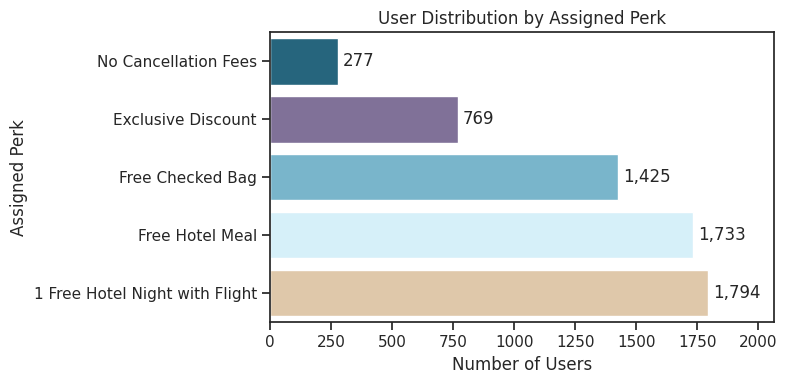

In [0]:
# Distribution of users by assigned perk - count plot
perk_counts = (
    seg_df["assigned_perk"]
    .value_counts()
    .sort_values(ascending=True)
)

plt.figure(figsize=(8, 4))

sns.barplot(
    x=perk_counts.values,
    y=perk_counts.index,
    hue = perk_counts.values,
    palette = travel_palette[0:5],
    legend=False
)

plt.title("User Distribution by Assigned Perk")
plt.xlabel("Number of Users")
plt.ylabel("Assigned Perk")
max_val = perk_counts.values.max()
plt.xlim(0, max_val * 1.15) 

# labels on the right of the bars with number of users
for i, v in enumerate(perk_counts.values):
    plt.text(v + 20, i, f"{v:,}", va="center")

plt.tight_layout()
plt.show()


**Note**: This chart shows the final distribution of users across perks.  
The distribution of perks reflects the assignment logic derived from observed user behaviors across segments. Differences in volume do not indicate inherent user preference for specific perks; they result from segment composition and the eligibility rules defined in the model.

###### Rule-based vs Fallback Assigment

In [0]:
# Distribution of assigned perks with fallback assignments
comparison = (
    seg_df.groupby(["perk_source", "assigned_perk"], dropna=False)
      .agg(users=("user_id", "count"))
      .reset_index()
      .rename(columns={"perk_source": "source"})
)
display(comparison)
# display the share of rule-based and fallback assignments
share_rule = (seg_df["perk_source"] == "Rule-based").mean().round(3)
share_fallback = (seg_df["perk_source"] == "Fallback").mean().round(3)
print("Rule-based:", share_rule, "Fallback:", share_fallback)


,source,assigned_perk,users
0,Fallback,Free Hotel Meal,214
1,Rule-based,1 Free Hotel Night with Flight,1794
2,Rule-based,Exclusive Discount,769
3,Rule-based,Free Checked Bag,1425
4,Rule-based,Free Hotel Meal,1519
5,Rule-based,No Cancellation Fees,277


Rule-based: 0.964 Fallback: 0.036


**Note**: Most users receive a perk through explicit eligibility rules.
Fallback is used only to guarantee universal coverage.

The rule-based segmentation assigns perks as **friction-removal levers**, not generic rewards.  
Each perk addresses a specific behavioral need (risk, complexity, engagement, or value). 

This framework provides a transparent, business-aligned baseline against which data-driven clustering can be evaluated and interpreted.

### 5. Clustering (Data-Driven Segmentation)

#### 5.1 Introduction

This section applies unsupervised clustering techniques to explore whether users naturally group into coherent segments when no explicit business rules are imposed.

Clustering is not used as an operational segmentation tool, but as an analytical validation layer:

- To test the robustness of the rule-based framework
- To uncover emergent behavioral archetypes
- To identify blind spots or unexpected patterns

Two complementary clustering perspectives are explored:

1. **Demographic clustering**: structural user characteristics
2. **Behavioral clustering**: observed engagement, trip structure, and reliability

Clustering results are therefore interpreted relative to, not instead of, the rule-based framework.

#### 5.2 Clustering Strategy and Design Principles

Clustering is designed according to the following principles:
- No composite scores (RFM, CLTV) are used as inputs
- No business-derived tiers or perk assignments are included
- All features are numerical and standardized
- Interpretation is performed **after** clustering, not before

This ensures that clustering remains exploratory rather than confirmatory.

#### 5.3 Demographic Clustering

##### 5.3.1 Objective

Demographic clustering focuses on **who the users are**, independent of how they travel or book.

The goal is to assess whether demographic and lifecycle attributes alone are sufficient to produce meaningful segmentation, and to provide a baseline for comparison with behavioral clustering.

##### 5.3.2 Feature Selection

Only structural user attributes are included:

In [0]:
# Choose only structural demographic features
# Age is computed at the user's last observed session to ensure temporal consistency
# with the observed activity window.
demographic_features = [
    "age",           # age at last observed activity
    "married",       # household structure indicator
    "has_children",  # family constraint
    "tenure_days"    # observed platform tenure (first to last session)
]

##### 5.3.3 Scaling

In [0]:
# Scale demographic features
X_demo = clu_df[demographic_features].copy()
X_demo = X_demo.astype(float)

scaler = StandardScaler()
X_demo_scaled = scaler.fit_transform(X_demo)


##### 5.3.4 Model Selection

K-Means is used as the primary clustering algorithm.

The optimal number of clusters is evaluated using:
- Elbow method
- Silhouette score

###### Elbow Method

To determine the optimal number of clusters for K-Means, the Elbow Method is applied.

The distortion (inertia, within-cluster sum of squares) is computed for different values of k.

The point where the curve begins to flatten indicates a good trade-off between cluster compactness and model simplicity.

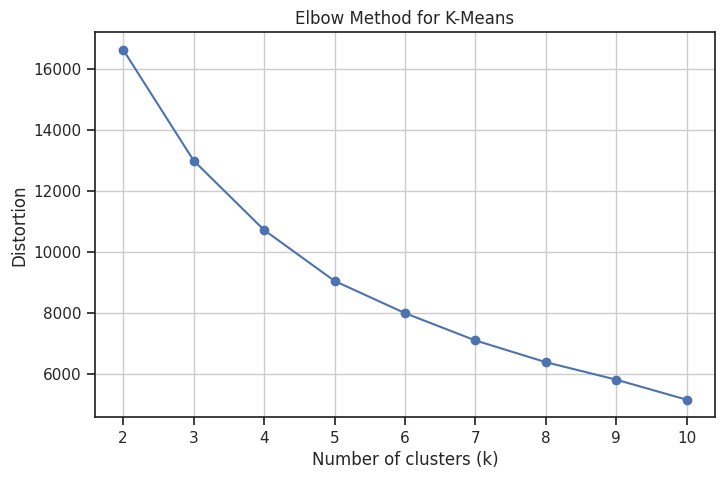

In [0]:
# Compute distortion values for different k to apply the Elbow Method
distortion = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
    kmeans.fit(X_demo_scaled)
    distortion.append(kmeans.inertia_)

# Plot the distortion curve
plt.figure(figsize=(8,5))
plt.plot(K, distortion, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Distortion")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()

**Note**: The elbow curve shows a pronounced reduction in distortion up to k=4, with a visible change in slope between k=4 and k=5.
Beyond this point, additional clusters yield diminishing marginal improvements.

###### Silhouette Score

The silhouette score is used to validate the optimal number of clusters suggested by the Elbow Method.

Higher silhouette values indicate better-defined clusters.

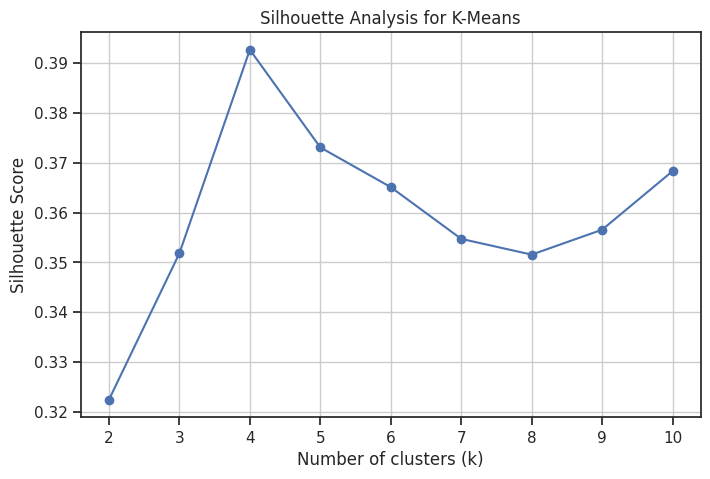

In [0]:
# Silhouette Analysis to evaluate clustering quality across different values of k
silhouette_scores = []

# Loop through each candidate value of k
for k in K:
  # Fit K-Means with current number of clusters
  kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
  labels = kmeans.fit_predict(X_demo_scaled)

  score = silhouette_score(X_demo_scaled, labels)
  silhouette_scores.append(score)

# Plot the Silhouette Scores curve
plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for K-Means")
plt.grid(True)
plt.show()

**Note**: Silhouette scores peak at k=4, indicating the strongest cluster separation and internal cohesion.
While k=5 can provide acceptable separation, it does so at the cost of reduced compactness.

Taken together with the elbow method, k=4 emerges as the most balanced solution.

##### 5.3.5 Cluster Assignment k = 4

In [0]:
# Fit KMeans (k=4)
kmeans_demo_4 = KMeans(
    n_clusters=4,
    random_state=3,
    n_init=10
)

clu_df["demo_cluster_k4"] = kmeans_demo_4.fit_predict(X_demo_scaled)


##### 5.3.6 Demographic Clustering Profiling

In [0]:
demo_cluster_profile = (
    clu_df
    .groupby("demo_cluster_k4")[demographic_features]
    .mean()
    .round(2)
)

display(demo_cluster_profile)

,age,married,has_children,tenure_days
demo_cluster_k4,,,,
0,45.13,1.00,1.0,140.41
1,48.87,0.96,0.0,141.03
2,35.39,0.00,0.0,141.75
3,35.35,0.00,1.0,140.66


In [0]:
# Cluster dimensions
clu_df["demo_cluster_k4"].value_counts().sort_index()

demo_cluster_k4
0    1084
1    1618
2    2422
3     874
Name: count, dtype: int64

**Note**: Demographic clustering produces four groups differentiated primarily by
age and household structure.

Observed tenure is highly consistent across clusters, reflecting the cohort definition
rather than demographic differences in platform exposure.

The resulting clusters align closely with the available demographic degrees of freedom,
providing a clean structural segmentation that will be used as a reference layer
for comparison with behavioral clustering.

This confirms that demographics alone offer limited explanatory power for travel behavior.

###### Cluster Name 

In [0]:
cluster_name_map = {
    0: "Established Families",
    1: "Mature Couples",
    2: "Young Singles",
    3: "Young Families",
}

clu_df["demo_cluster_name"] = clu_df["demo_cluster_k4"].map(cluster_name_map)

# Quick sanity check
display(clu_df[["demo_cluster_k4", "demo_cluster_name"]].drop_duplicates().sort_values("demo_cluster_k4"))
display(clu_df["demo_cluster_name"].value_counts())

,demo_cluster_k4,demo_cluster_name
2,0,Established Families
0,1,Mature Couples
8,2,Young Singles
5,3,Young Families


demo_cluster_name
Young Singles           2422
Mature Couples          1618
Established Families    1084
Young Families           874
Name: count, dtype: int64

**Note**: Demographic clusters are driven almost entirely by age and household structure, while platform tenure remains constant across groups.

These clusters are intentionally **descriptive rather than prescriptive**: they provide context about *who* the users are, but do not explain *how* they travel
or *why* they respond to specific perks.

For this reason, demographic clusters are not used in perk assignment.  
All incentive logic is grounded in behavioral signals rather than personal attributes.


#### 5.4 Behavioral Clustering

##### 5.4.1 Objective

##### 5.4.2 Feature Selection

Behavioral clustering is performed using interaction, booking, trip anatomy, and spend structure features.  
No business rules, tiers, or personas are included in the feature space.

In [0]:
# define features to use for clustering
behavioral_features = [
    # Engagement
    "n_sessions",
    "booking_rate",

    # Reliability
    "conversion_rate",

    # Presence flags (already in dataset)
    "has_flight_history",
    "has_hotel_history",

    # Trip intensity (0 = meaningful only with presence flags)
    "avg_nights",
    "avg_rooms",
    "avg_distance_km",
    "avg_seats",
    "avg_checked_bags",
    "avg_trip_duration_days",

    # Spend
    "avg_spend_per_trip"
]

X_behavioral = clu_df[behavioral_features].copy()


**Note**: These features capture how users behave, not who they are.
Presence flags are used to disambiguate zero-valued trip intensity features.

These features were selected to reflect decisions and constraints observed in actual travel behavior.

##### 5.4.3 Scaling

In [0]:
# Scale behavioral features
scaler = StandardScaler()
X_behavioral_scaled = scaler.fit_transform(X_behavioral)

##### 5.4.4 Model Selection

K-Means is used as the primary clustering algorithm.

The optimal number of clusters is evaluated using:
- Elbow method
- Silhouette score

###### Elbow Method

To determine the optimal number of clusters for K-Means, the Elbow Method is applied.

The distortion (inertia, within-cluster sum of squares) is computed for different values of k.

The point where the curve begins to flatten indicates a good trade-off between cluster compactness and model simplicity.

In [0]:
# Check NaN presence in behavioral clustering features
nan_check = (
    clu_df[behavioral_features]
    .isna()
    .mean()
    .sort_values(ascending=False)
)

display(nan_check)

n_sessions                0.0
booking_rate              0.0
conversion_rate           0.0
has_flight_history        0.0
has_hotel_history         0.0
avg_nights                0.0
avg_rooms                 0.0
avg_distance_km           0.0
avg_seats                 0.0
avg_checked_bags          0.0
avg_trip_duration_days    0.0
avg_spend_per_trip        0.0
dtype: float64

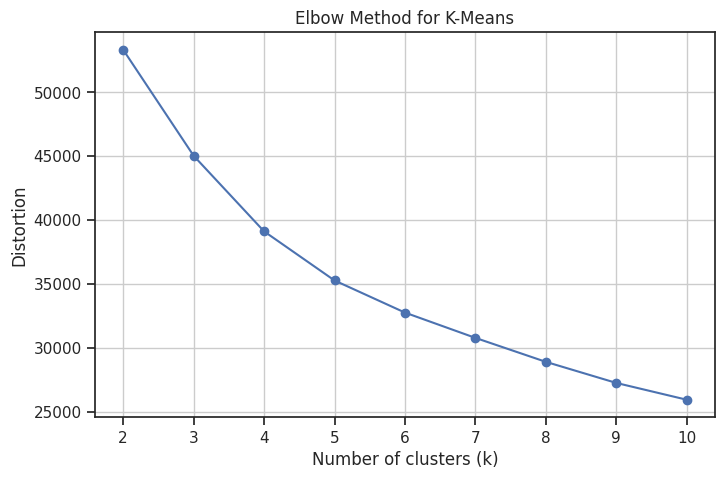

In [0]:
# Compute distortion values for different k to apply the Elbow Method
distortion = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
    kmeans.fit(X_behavioral_scaled)
    distortion.append(kmeans.inertia_)

# Plot the distortion curve
plt.figure(figsize=(8,5))
plt.plot(K, distortion, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Distortion")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()

**Note**: The elbow curve shows a strong reduction in distortion when moving from **k = 2** to **k = 4**, after which the marginal gain decreases more gradually.   
The most pronounced change in slope occurs around **k = 4-5**, suggesting that these values capture the main structural separation in behavioral patterns. 
 
Beyond k = 5, additional clusters mainly reduce within-cluster variance without revealing clearly distinct behavioral groups, indicating diminishing returns in interpretability.


###### Silhouette Score

The silhouette score is used to validate the optimal number of clusters suggested by the Elbow Method.

Higher silhouette values indicate better-defined clusters.


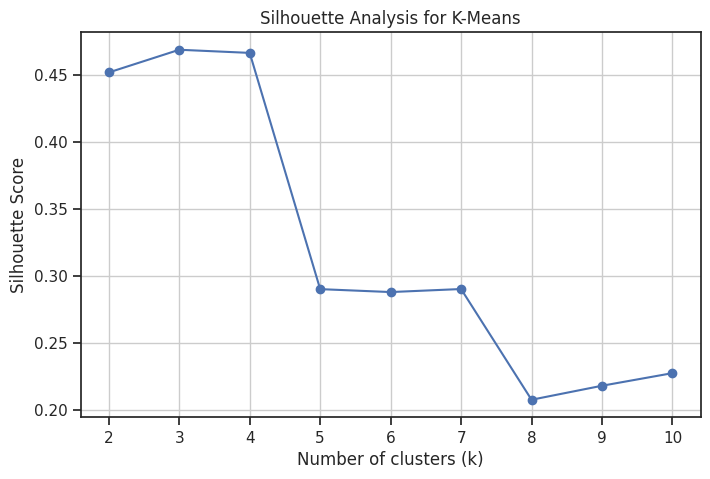

In [0]:
# Silhouette Analysis to evaluate clustering quality across different values of k
silhouette_scores = []

# Loop through each candidate value of k
for k in K:
  # Fit K-Means with current number of clusters
  kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
  labels = kmeans.fit_predict(X_behavioral_scaled)

  score = silhouette_score(X_behavioral_scaled, labels)
  silhouette_scores.append(score)

# Plot the Silhouette Scores curve
plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for K-Means")
plt.grid(True)
plt.show()

**Note**: The silhouette score peaks at **k = 3** and remains comparably high at **k = 4**, indicating good cluster separation and internal cohesion for both configurations.   
From **k ≥ 5**, the silhouette score drops sharply, signaling increasing overlap between clusters and weaker separation.

This suggests that solutions with more than four clusters fragment existing behavioral groups rather than uncovering new, well-defined ones.

###### Choice of k

Combining elbow and silhouette results:

**k = 4** provides the clearest and most stable behavioral segmentation, with strong separation and high interpretability.

The final choice will be guided by **cluster interpretability and business usefulness**, rather than by metric optimization alone.

##### 5.4.5 Fit K-Means

In [0]:
# K = 4
kmeans_4 = KMeans(
    n_clusters=4,
    random_state=3,
    n_init=20
)
clu_df["cluster_k4"] = kmeans_4.fit_predict(X_behavioral_scaled)

###### Cluster Size 

In [0]:
# cluster distribution
clu_df["cluster_k4"].value_counts().sort_index()

cluster_k4
0     371
1     287
2     543
3    4797
Name: count, dtype: int64

**Note**: The behavioral clustering produces one dominant cluster and three smaller, more specialized clusters.  
This is expected given the cohort design and reflects a large base of standard users, alongside distinct behavioral outliers characterized by different levels of commitment, complexity, or value.

This imbalance is informative rather than problematic.

In [0]:
# Compute mean behavioral profile for each K=4 cluster
cluster_profile_k4 = (
    clu_df
    .groupby("cluster_k4")[behavioral_features]
    .mean()
    .round(2)
)

display(cluster_profile_k4)


,n_sessions,booking_rate,conversion_rate,has_flight_history,has_hotel_history,avg_nights,avg_rooms,avg_distance_km,avg_seats,avg_checked_bags,avg_trip_duration_days,avg_spend_per_trip
cluster_k4,,,,,,,,,,,,
0,8.18,0.16,0.98,0.01,1.0,7.94,1.33,6.35,0.01,0.00,0.00,1863.98
1,8.21,0.24,0.46,1.00,0.8,6.51,1.01,6323.38,1.88,1.05,11.58,5055.92
2,8.15,0.02,1.00,0.14,0.0,0.00,0.00,306.29,0.16,0.07,0.58,61.69
3,8.17,0.38,0.98,1.00,1.0,4.02,1.18,2124.10,1.18,0.57,4.94,1172.03


**Note**: The raw cluster profiles already reveal clear behavioral archetypes:  
**non-bookers**, **hotel-centric travelers**, **high-stakes complex travelers**, and a large core of **reliable, balanced users**.

###### Silhouette Score

In [0]:
# Silhouette score: evaluates how well-separated and cohesive the final clusters are
# Silhouette score for K=4 clustering
silhouette_k4 = silhouette_score(
    X_behavioral_scaled,        # Feature matrix used for clustering
    clu_df["cluster_k4"]        # Cluster labels assigned by KMeans
)                               # Higher = better separation

print(f"Silhouette score (k=4): {silhouette_k4:.3f}")


Silhouette score (k=4): 0.467


**Note**: The final K=4 clustering achieves a silhouette score of 0.467.  
A strong result for behavioral segmentation based solely on raw user activity features (sessions, cancellations, conversions, product usage, and trip attributes).  
It indicates that the clusters are well-separated and cohesive despite the inherent noise and variability typical of behavioral data.

##### 5.4.6 Comparing Cluster

###### z-score table

In [0]:
from scipy.stats import zscore

# K = 4
z_profile_k4 = (
    clu_df
    .groupby("cluster_k4")[behavioral_features]
    .mean()
    .apply(zscore)
    .round(2)
)

display(z_profile_k4)


,n_sessions,booking_rate,conversion_rate,has_flight_history,has_hotel_history,avg_nights,avg_rooms,avg_distance_km,avg_seats,avg_checked_bags,avg_trip_duration_days,avg_spend_per_trip
cluster_k4,,,,,,,,,,,,
0,0.12,-0.33,0.55,-1.14,0.73,1.10,0.87,-0.87,-1.04,-1.00,-0.92,-0.09
1,1.54,0.29,-1.73,0.99,0.25,0.63,0.25,1.64,1.40,1.48,1.58,1.62
2,-1.16,-1.36,0.63,-0.85,-1.70,-1.53,-1.69,-0.75,-0.84,-0.83,-0.80,-1.06
3,-0.50,1.40,0.55,0.99,0.72,-0.20,0.57,-0.03,0.49,0.35,0.14,-0.47


**Note**: Z-score normalization highlights that clusters differ primarily along three orthogonal dimensions:
- Decision commitment 
- Trip complexity
- Economic intensity

The dominant cluster represents standardized, **reliable behavior**, while smaller clusters capture structurally **different travel styles rather than noise**.

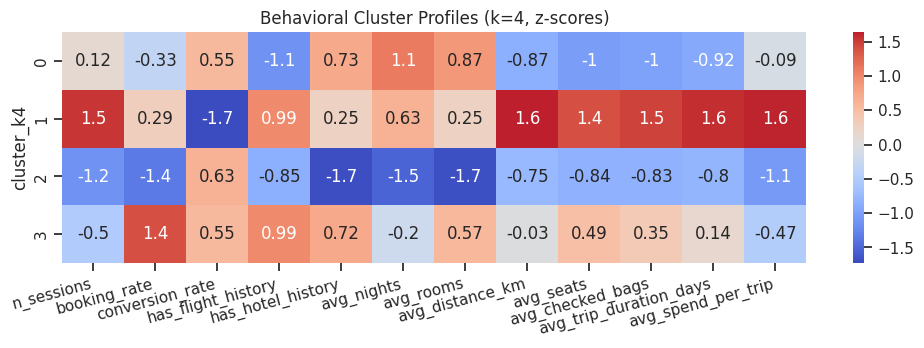

In [0]:
plt.figure(figsize=(12, 3))
sns.heatmap(
    z_profile_k4,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Behavioral Cluster Profiles (k=4, z-scores)")
plt.xticks(rotation=15, ha="right")
plt.show()

**Note**: This heatmap provides a visual summary of the z-score profiles.

Clusters are clearly separated along three independent dimensions:
**decision commitment (booking & conversion), trip complexity, and economic intensity**.  
The dominant cluster represents standardized behavior, while smaller clusters capture structurally different travel archetypes rather than noise.

###### Naming Clusters

In [0]:
# Behavioral features used to characterize and interpret clusters
behavioral_features = [
    "n_sessions",
    "booking_rate",
    "conversion_rate",
    "has_flight_history",
    "has_hotel_history",
    "avg_nights",
    "avg_rooms",
    "avg_distance_km",
    "avg_seats",
    "avg_checked_bags",
    "avg_trip_duration_days",
    "avg_spend_per_trip",
]
# Compute average behavioral profile per cluster (K=4)
cluster_profile = (
    clu_df.groupby("cluster_k4")[behavioral_features]
      .mean(numeric_only=True)
      .round(2)
)

# Cluster sizes for scale and representativeness
cluster_sizes = clu_df["cluster_k4"].value_counts().sort_index()

display(cluster_profile)
display(cluster_sizes.to_frame("users"))


,n_sessions,booking_rate,conversion_rate,has_flight_history,has_hotel_history,avg_nights,avg_rooms,avg_distance_km,avg_seats,avg_checked_bags,avg_trip_duration_days,avg_spend_per_trip
cluster_k4,,,,,,,,,,,,
0,8.18,0.16,0.98,0.01,1.0,7.94,1.33,6.35,0.01,0.00,0.00,1863.98
1,8.21,0.24,0.46,1.00,0.8,6.51,1.01,6323.38,1.88,1.05,11.58,5055.92
2,8.15,0.02,1.00,0.14,0.0,0.00,0.00,306.29,0.16,0.07,0.58,61.69
3,8.17,0.38,0.98,1.00,1.0,4.02,1.18,2124.10,1.18,0.57,4.94,1172.03


,users
cluster_k4,
0,371
1,287
2,543
3,4797


**Note**: Cluster sizes are intentionally unbalanced. A dominant “core” cluster is expected in TravelTide because most users follow standard booking behavior, while only a minority exhibits hotel-only planning, high-stakes long-haul behavior, or near-browsing patterns.  
Small clusters are still valuable: they isolate edge behaviors that are operationally meaningful (fragile high-stakes planners).

###### Cluster Names

In [0]:
# Human-readable labels for K=4 behavioral clusters
cluster_name_map = {
    0: "Hotel-led Planners",
    1: "High-stakes & Fragile",
    2: "Browsers",
    3: "Core Reliable Bookers",
}

# Map numeric cluster IDs to interpretable names
clu_df["behavior_cluster"] = clu_df["cluster_k4"].astype(int)
clu_df["behavior_cluster_name"] = clu_df["behavior_cluster"].map(cluster_name_map)

# Quick sanity check: label mapping and cluster distribution
display(clu_df[["behavior_cluster", "behavior_cluster_name"]].drop_duplicates().sort_values("behavior_cluster"))
display(clu_df["behavior_cluster_name"].value_counts())

,behavior_cluster,behavior_cluster_name
0,0,Hotel-led Planners
4,1,High-stakes & Fragile
8,2,Browsers
1,3,Core Reliable Bookers


behavior_cluster_name
Core Reliable Bookers    4797
Browsers                  543
Hotel-led Planners        371
High-stakes & Fragile     287
Name: count, dtype: int64

- **Cluster 3 (dominant): Core Reliable Bookers**  
High booking_rate, high conversion_rate, both histories present, mid trip intensity, mid spend.

- **Cluster 1 (small, high spend + low conversion): High-stakes & Fragile**   
Very high distance/duration/bags/seats, highest spend per trip, but low conversion and highest cancellation.

- **Cluster 0 (hotel-heavy, flight almost absent): Hotel-led Planners**  
Hotel history ~1, very high nights/rooms, flight history ~0, spend relatively high.

- **Cluster 2 (almost 0 booking sessions): Browsers**


###### Visualize Clusters in PCA Space

To visualize high-dimensional behavioral clusters, a PCA projection is used.
This visualization does not drive clustering, but helps interpret how clusters differ along dominant behavioral axes.

In [0]:
# X_behavioral used for clustering
X = X_behavioral.copy()

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2 components
pca = PCA(n_components=2, random_state=3)
X_pca = pca.fit_transform(X_scaled)

# how much variance is 
explained_var = pca.explained_variance_ratio_
print(f"PCA variance explained: {explained_var.sum():.2%}")

# DataFrame for plotting
pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)
pca_df["behavior_cluster"] = clu_df["behavior_cluster_name"].values


PCA variance explained: 51.54%


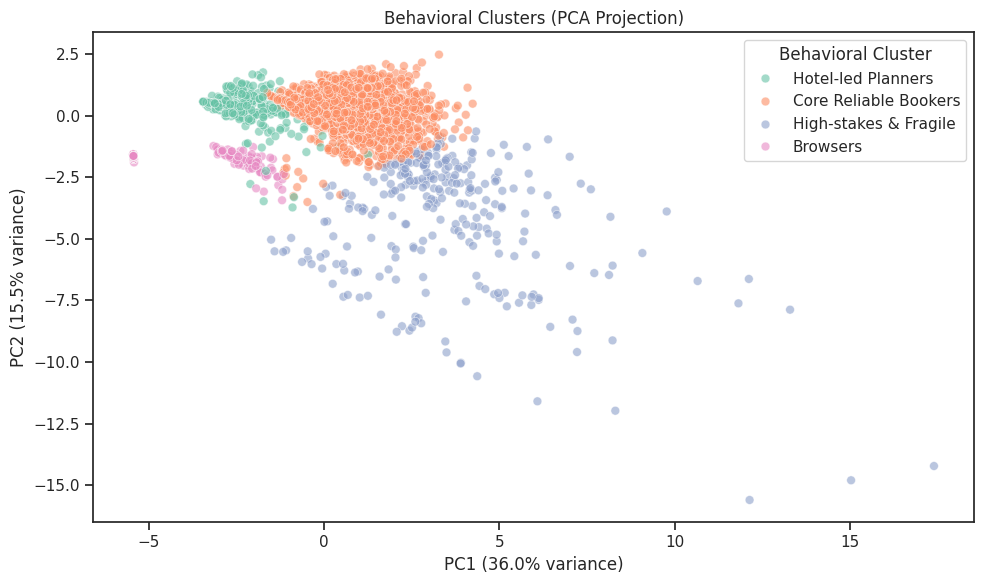

In [0]:
# Plot clusters
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="behavior_cluster",
    palette="Set2",
    alpha=0.6,
    s=40
)

plt.title("Behavioral Clusters (PCA Projection)")
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.legend(title="Behavioral Cluster", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

**Note**: The PCA projection provides a visual intuition of the behavioral clustering in a reduced two-dimensional space.   
While partial overlap is expected due to dimensionality reduction, the plot highlights clear structural differences between clusters, particularly for non-bookers and high-stakes users.
This visualization supports, but does not replace, the analytical validation performed through z-score profiling and downstream mappings.

###### Demographic Cluster x Behavioral Cluster

In [0]:
# Crosstab: demographic cluster x behavioral cluster (row-normalized)
demo_behav_ct = (
    pd.crosstab(
        clu_df["demo_cluster_k4"],
        clu_df["cluster_k4"],  
        normalize="index"
    )
    .round(3)
)

display(demo_behav_ct)


cluster_k4,0,1,2,3
demo_cluster_k4,,,,
0,0.061,0.060,0.077,0.803
1,0.061,0.047,0.098,0.795
2,0.059,0.041,0.084,0.816
3,0.073,0.054,0.112,0.761


**Note**: The cross-tabulation between demographic and behavioral clusters shows no strong alignment.  
Each demographic group is largely distributed across the same dominant behavioral cluster, confirming that **travel behavior is not driven by demographic attributes**.

In [0]:
# Attach clustering-based behavioral archetypes to the segmentation table

# df is the final segmentation dataset (seg_df) enriched with behavioral clustering labels
# (cluster_k4 was computed on clu_df, then merged back to df via user_id)
df = seg_df.copy()
df = seg_df.merge(
    clu_df[["user_id", "demo_cluster_k4", "demo_cluster_name", "cluster_k4", "behavior_cluster_name"]],
    on="user_id",
    how="left"
)

In [0]:
# Required columns check
required = ["cluster_k4", "RFM_persona", "assigned_perk", "cancellation_rate", "conversion_rate"]
missing = [c for c in required if c not in df.columns]
print("Missing:", missing)


Missing: []


##### Cluster x  Rule-Based Tiers Comparison

In [0]:

# Cluster vs Rule-Based Tiers (share per cluster + dominand tier)
# Evaluate how each behavioral cluster distributes across the rule-based tiers.
tiers = ["value_tier", "risk_tier", "complexity_tier", "engagement_tier"]

cluster_tier_tables = {}
# For each rule-based tier, compute the percentage distribution of users
# within each behavioral cluster.
for tier in tiers:
    table = (
        df
        .groupby("behavior_cluster_name")[tier]
        .value_counts(normalize=True)
        .rename("share")
        .mul(100)
        .round(2)
        .unstack(fill_value=0)
        .sort_index()
    )
    
    cluster_tier_tables[tier] = table

    print(f"\n### {tier} vs cluster")
    # Dominant tier per cluster
    table_with_dominant = table.copy()
    table_with_dominant["dominant_tier"] = table.idxmax(axis=1)
    display(table_with_dominant)


### value_tier vs cluster


value_tier,Low,Mid,High,dominant_tier
behavior_cluster_name,,,,
Browsers,100.00,0.00,0.00,Low
Core Reliable Bookers,56.76,34.48,8.76,Low
High-stakes & Fragile,19.86,25.78,54.36,High
Hotel-led Planners,74.39,19.14,6.47,Low



### risk_tier vs cluster


risk_tier,None,Low,Medium,High,dominant_tier
behavior_cluster_name,,,,,
Browsers,99.45,0.00,0.00,0.55,None
Core Reliable Bookers,92.83,1.46,4.50,1.21,None
High-stakes & Fragile,19.16,0.35,20.56,59.93,High
Hotel-led Planners,96.77,0.00,0.54,2.70,None



### complexity_tier vs cluster


complexity_tier,Simple,Moderate,Complex,dominant_tier
behavior_cluster_name,,,,
Browsers,96.50,2.58,0.92,Simple
Core Reliable Bookers,72.86,22.16,4.98,Simple
High-stakes & Fragile,5.57,16.72,77.70,Complex
Hotel-led Planners,45.82,18.33,35.85,Simple



### engagement_tier vs cluster


engagement_tier,Low,Mid,High,dominant_tier
behavior_cluster_name,,,,
Browsers,97.79,2.21,0.00,Low
Core Reliable Bookers,18.97,40.80,40.23,Mid
High-stakes & Fragile,11.85,57.49,30.66,Mid
Hotel-led Planners,66.58,28.57,4.85,Low


**Note**: These tables compare each behavioral cluster with the rule-based tiers (shares are computed **within cluster**, so each row sums to 100%). 

Even though K-Means was trained only on behavioral features (no tiers, no composite scores, no perk logic), the resulting clusters align strongly with the four manual dimensions: **Value, Risk, Complexity, and Engagement**.   
This is a useful sanity check: the rule-based framework is not only driven by arbitrary thresholds, but it reflects structure that emerges naturally from the data.


**Value**: High-value users concentrate in **High-stakes & Fragile** (54% High), while **Browsers** are entirely Low value (100%) as expected.  

**Risk**: Separation is extremely sharp. **High-stakes & Fragile** contains the majority of High risk users (≈60%), while the other clusters are overwhelmingly None/Low. 

**Complexity**: Complexity is the strongest structural separator. **High-stakes & Fragile** is predominantly Complex (≈72%), while **Browsers** are almost entirely Simple (≈97%).  

**Engagement**: Engagement follows a coherent pattern: **Core Reliable Bookers** skew Mid/High, while **Hotel-led Planners** and **Browsers** are mostly Low.

**The clusters behave like “joint distributions” of the tiers.**

**Overall Insights**:   
Although the clustering model does not use any business tiers or composite scores as inputs, the resulting behavioral clusters naturally reproduce the four rule-based dimensions (Value, Risk, Complexity, Engagement).

This alignment strongly suggests that the manual segmentation framework is grounded in real behavioral structure rather than arbitrary thresholds, providing validation for the perk assignment logic.

##### Cluster x RFM Persona

###### Crostab Counts + Share by Cluster

In [0]:
cluster_rfm_counts = pd.crosstab(df["behavior_cluster_name"], df["RFM_persona"])
cluster_rfm_share = pd.crosstab(df["behavior_cluster_name"], df["RFM_persona"], normalize="index").round(3)

display(cluster_rfm_counts)
display(cluster_rfm_share)

RFM_persona,At Risk,Big Spenders,Can't Lose Them,Champions,Hibernating,Loyal Customers,Need Attention,Potential Loyalists
behavior_cluster_name,,,,,,,,
Browsers,0,0,0,0,517,0,8,18
Core Reliable Bookers,624,533,249,871,686,599,505,730
High-stakes & Fragile,20,143,66,8,16,4,14,16
Hotel-led Planners,2,42,72,0,161,0,41,53


RFM_persona,At Risk,Big Spenders,Can't Lose Them,Champions,Hibernating,Loyal Customers,Need Attention,Potential Loyalists
behavior_cluster_name,,,,,,,,
Browsers,0.000,0.000,0.000,0.000,0.952,0.000,0.015,0.033
Core Reliable Bookers,0.130,0.111,0.052,0.182,0.143,0.125,0.105,0.152
High-stakes & Fragile,0.070,0.498,0.230,0.028,0.056,0.014,0.049,0.056
Hotel-led Planners,0.005,0.113,0.194,0.000,0.434,0.000,0.111,0.143


###### Heatmap (share)

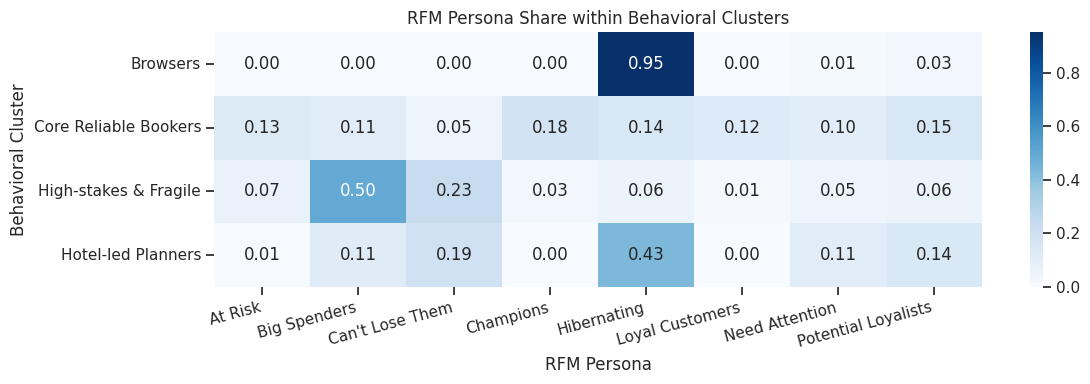

In [0]:
plt.figure(figsize=(12, 4))
sns.heatmap(cluster_rfm_share, annot=True, fmt=".2f", cmap="Blues")
plt.title("RFM Persona Share within Behavioral Clusters")
plt.xlabel("RFM Persona")
plt.ylabel("Behavioral Cluster")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

**Note**: This mapping is a validation layer: RFM personas are behavior summaries at user level, while clusters capture multi-dimensional structure (product mix, trip intensity, commitment).  
The alignment is strong but not redundant: clusters refine how users travel and commit, while RFM explains when/how often/how much they book.

Insights:

- **Browsers** concentrates Hibernating users because the mostly only browser activity, confirming minimal booking activity from the few users in this cluster that have some booking trip. This is driven by uncertainty: these users doesn't convert and the users with a booking session, cancell always the trip.

- **Core Reliable Bookers** contains a balanced mix of personas, including Champions, Loyal Customers and Potential Loyalists, consistent with stable conversion.

- **High-stakes & Fragile** over-indexes on **Big Spenders** and **Can't Lose Them**, indicating high value potential paired with fragility.

- **Hotel-led Planners** leans toward **Hibernating** / **Can't Lose Them**, suggesting hotel-centric users with weaker recency/frequency.

This confirms that clustering adds structure beyond traditional RFM summaries.


##### Cluster x Assigned Perk

###### Crosstab Counts + Share by Cluster

In [0]:
# Cross tab 
cluster_perk_counts = pd.crosstab(df["behavior_cluster_name"], df["assigned_perk"])
cluster_perk_share = pd.crosstab(df["behavior_cluster_name"], df["assigned_perk"], normalize="index").round(3)

display(cluster_perk_counts)
display(cluster_perk_share)

assigned_perk,1 Free Hotel Night with Flight,Exclusive Discount,Free Checked Bag,Free Hotel Meal,No Cancellation Fees
behavior_cluster_name,,,,,
Browsers,0,466,19,58,0
Core Reliable Bookers,1794,281,1231,1275,216
High-stakes & Fragile,0,0,173,54,60
Hotel-led Planners,0,22,2,346,1


assigned_perk,1 Free Hotel Night with Flight,Exclusive Discount,Free Checked Bag,Free Hotel Meal,No Cancellation Fees
behavior_cluster_name,,,,,
Browsers,0.000,0.858,0.035,0.107,0.000
Core Reliable Bookers,0.374,0.059,0.257,0.266,0.045
High-stakes & Fragile,0.000,0.000,0.603,0.188,0.209
Hotel-led Planners,0.000,0.059,0.005,0.933,0.003


###### Heatmap Perk Share within Behavioral Clusters

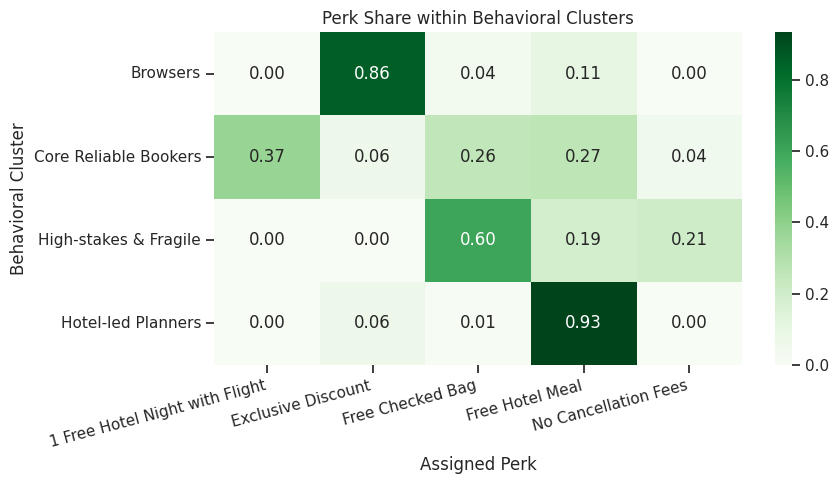

In [0]:
# Visualize perk allocation patterns across behavioral clusters
plt.figure(figsize=(9,5))
sns.heatmap(cluster_perk_share, annot=True, fmt=".2f", cmap="Greens")
plt.title("Perk Share within Behavioral Clusters")
plt.xlabel("Assigned Perk")
plt.ylabel("Behavioral Cluster")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

**Note**: Perk allocation is coherent with cluster needs, which is expected because eligibility rules were designed around risk, complexity, engagement, and product presence.  
The heatmap is used here as a sanity check to ensure that rule-based perks concentrate where their behavioral rationale is strongest.

Insights:

- **Exclusive Discount** is almost entirely allocated to the **Browsers** cluster, reflecting an expansion strategy. These users never book; the discount is used to stimulate activation.

- **Free Hotel Meal** dominates **Hotel-led Planners**, matching the hotel-centric experience uplift rationale.

- **High-stakes & Fragile** receives mostly **Free Checked Bag** and **No Cancellation Fees**, reflecting logistics + reassurance needs.

- **Core Reliable Bookers** receives the broad mix (mostly Free Night with Flight, Checked Bag, Meal), consistent with being the main “conversion-ready” population.

This alignment is expected, but not guaranteed, and serves as a consistency check.

###### Assigned Perks by Segmentation vs Behavioral Cluster - Bar Plot 

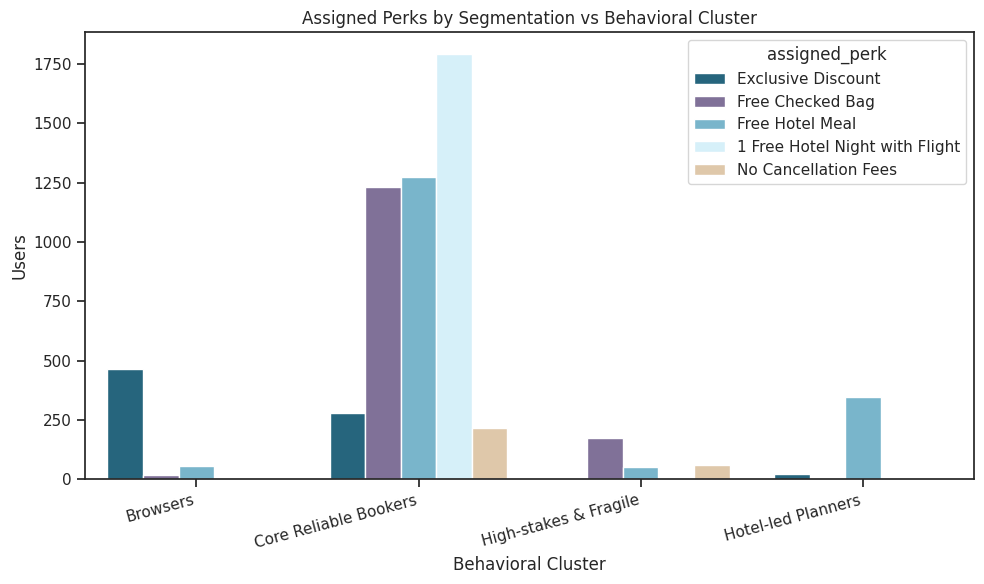

In [0]:
# Distribution of perks into each cluster - bar plot
tmp = (
    df.groupby(["behavior_cluster_name", "assigned_perk"])
      .size()
      .reset_index(name="users")
)

plt.figure(figsize=(10, 6))
sns.barplot(data=tmp, x="behavior_cluster_name", y="users", hue="assigned_perk", palette = travel_palette[0:5])
plt.title("Assigned Perks by Segmentation vs Behavioral Cluster")
plt.xlabel("Behavioral Cluster")
plt.ylabel("Users")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()
 

**Note**: PCA is used only for visualization. Clusters are still defined in the full standardized feature space.   
The projection provides a qualitative check on separation and overlap.

Counts confirm that perk strategy mainly operates inside the **Core Reliable Bookers** cluster (largest population), while smaller clusters receive a narrower set of perks that match their primary friction (fragility vs hotel-centric vs light exploration).

##### Cluster x Cancellation / Conversion Distribution

###### Cancellation Rate Distribution - Box Plot

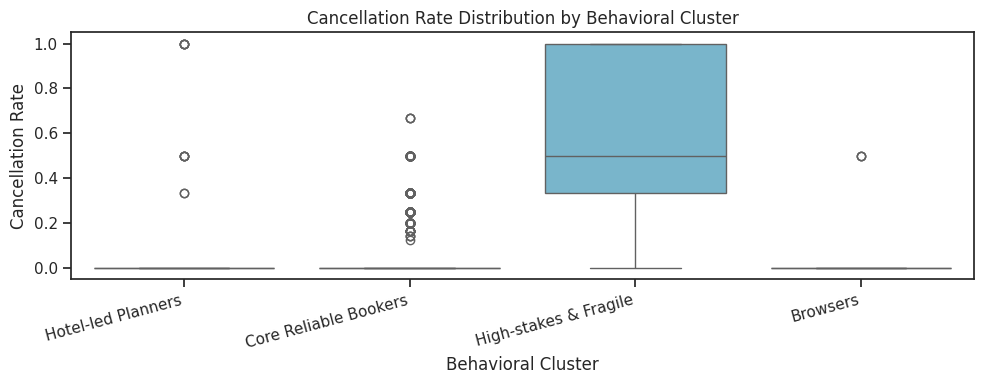

In [0]:
# Cancellation rate distribution by behavioral cluster box plot
plt.figure(figsize=(10, 4))

sns.boxplot(data=df, x="behavior_cluster_name", y="cancellation_rate", color= travel_palette[2])

plt.title("Cancellation Rate Distribution by Behavioral Cluster")
plt.xlabel("Behavioral Cluster")
plt.ylabel("Cancellation Rate")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

###### Conversion Rate Distribution - Box Pot

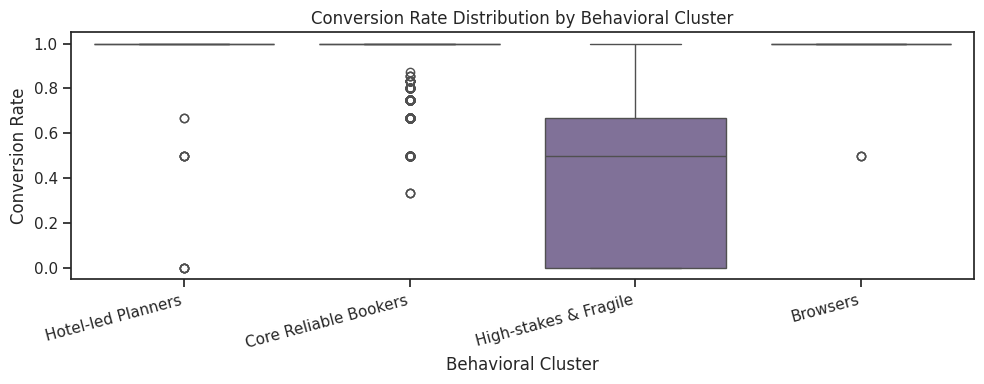

In [0]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="behavior_cluster_name", y="conversion_rate", color= travel_palette[1])
plt.title("Conversion Rate Distribution by Behavioral Cluster")
plt.xlabel("Behavioral Cluster")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

###### Summary Table (Median + Mean + Size)

In [0]:
# Risk summary table
risk_summary = (
    df.groupby("behavior_cluster_name")
      .agg(
          users=("user_id", "count"),
          mean_cancel=("cancellation_rate", "mean"),
          median_cancel=("cancellation_rate", "median"),
          mean_conv=("conversion_rate", "mean"),
          median_conv=("conversion_rate", "median"),
          mean_spend=("avg_spend_per_trip", "mean"),
      )
      .round(3)
      .sort_values("users", ascending=False)
)

display(risk_summary)

,users,mean_cancel,median_cancel,mean_conv,median_conv,mean_spend
behavior_cluster_name,,,,,,
Core Reliable Bookers,4797,0.022,0.0,0.978,1.0,1172.033
Browsers,543,0.003,0.0,0.997,1.0,435.056
Hotel-led Planners,371,0.022,0.0,0.978,1.0,1863.975
High-stakes & Fragile,287,0.536,0.5,0.464,0.5,5055.916


**Note**: Conversion and cancellation clearly separate one distinct risk-heavy cluster. Median values remain informative because most users have 0 cancellations; means highlight the tail risk.  
This confirms that fragility is cluster-specific rather than uniformly distributed.

High-stakes trips concentrate both **economic upside** (highest spend) and **commitment risk** (lowest conversion).

In [0]:
df.head()

,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,last_session_date,last_booking_date,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,total_flight_spend,total_hotel_spend,total_spend,cancelled_trips,booking_rate,cancellation_rate,conversion_rate,avg_session_duration,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days,age,avg_spend_per_trip,has_cancellation,R_days,R_score,F_score,M_score,RFM_score,RFM_segment,RFM_persona,CLTV_3m,has_flight_history,has_hotel_history,value_tier,risk_tier,complexity_score,complexity_tier,engagement_tier,n_completed_trips,very_low_risk,eligible_no_cancellation_fees,eligible_exclusive_discount,eligible_free_hotel_night_with_flight,eligible_free_checked_bag,eligible_free_hotel_meal,assigned_perk,perk_source,demo_cluster_k4,demo_cluster_name,cluster_k4,behavior_cluster_name
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,2023-07-14 12:36:00,2023-07-14 12:36:00,190,8,2,2,0.00,3802.0,3802.00,0,0.250,0.0,1.0,1.277083,10.250,NaN,NaN,10.0,18.0,NaN,1.5,NaN,NaN,NaN,64,1901.000,False,15.0,5,2,4,11,5-2-4,Big Spenders,1800.947368,False,True,Low,None,6.000000,Complex,High,2,True,False,False,False,False,True,Free Hotel Meal,Rule-based,1,Mature Couples,0,Hotel-led Planners
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,2023-05-28 17:28:00,2023-04-10 21:13:00,138,8,2,2,864.09,230.0,1094.09,0,0.250,0.0,1.0,1.129167,9.125,1453.666128,1536.436758,1.0,1.0,1.5,1.5,0.5,2.5,3.0,51,547.045,False,109.0,2,2,2,6,2-2-2,Hibernating,713.536957,True,True,Low,None,1.445367,Simple,Low,2,True,False,False,False,False,True,Free Hotel Meal,Rule-based,1,Mature Couples,3,Core Reliable Bookers
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,2023-07-18 09:35:00,2023-06-17 19:42:00,178,8,2,2,189.91,2452.0,2641.91,0,0.250,0.0,1.0,2.037500,16.375,965.340568,965.340568,4.5,5.0,1.0,1.5,0.0,5.0,5.0,50,1320.955,False,42.0,4,2,3,9,4-2-3,Potential Loyalists,1335.797191,True,True,Low,None,3.046534,Simple,Mid,2,True,False,False,False,False,True,Free Hotel Meal,Rule-based,0,Established Families,3,Core Reliable Bookers
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,2023-06-22 13:27:00,2023-06-22 13:27:00,154,8,5,5,1242.66,2798.0,4040.66,0,0.625,0.0,1.0,1.962500,15.750,1321.684183,4003.264513,4.4,8.0,1.0,1.0,0.4,5.8,9.0,42,808.132,False,37.0,4,5,4,13,4-5-4,Champions,2361.424675,True,True,Mid,None,3.372168,Simple,High,5,True,False,True,False,False,True,Exclusive Discount,Rule-based,1,Mature Couples,3,Core Reliable Bookers
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,2023-07-27 09:43:48,2023-06-06 09:41:00,197,8,1,2,27804.12,8514.0,36318.12,1,0.125,1.0,0.0,12.648584,30.000,13402.323077,13402.323077,11.0,11.0,6.0,3.0,5.0,14.0,14.0,44,36318.120,True,53.0,4,1,5,10,4-1-5,Big Spenders,16592.034518,True,True,High,High,10.440232,Complex,Mid,0,False,False,False,False,False,False,Free Hotel Meal,Fallback,0,Established Families,1,High-stakes & Fragile


### 6 Final Dataset

In [0]:
# Order of final dataset columns
cols_order = [
    # 1. Identity
    "user_id", "gender", "married", "birthdate", "has_children",
    "home_country", "home_city", "home_airport",

    # 2. Lifecycle
    "sign_up_date", "first_session_date", "last_session_date", "last_booking_date",
    "tenure_days",

    # 3. Behavior
    "n_sessions", "n_booking_sessions", "n_trip_sessions",
    "total_flight_spend", "total_hotel_spend", "total_spend",
    "cancelled_trips", "booking_rate", "cancellation_rate", "conversion_rate",
    "avg_session_duration", "avg_page_clicks",

    # 4. Trip structure
    "avg_distance_km", "max_distance_km",
    "avg_nights", "max_nights",
    "avg_seats", "avg_rooms", "avg_checked_bags",
    "avg_trip_duration_days", "max_trip_duration_days",
    "avg_spend_per_trip",

    # 5. Product signals
    "has_cancellation", "has_flight_history", "has_hotel_history",

    # 6. RFM
    "R_days", "R_score", "F_score", "M_score",
    "RFM_score", "RFM_segment", "RFM_persona",

    # 7. CLTV
    "CLTV_3m",

    # 8. Rule-based tiers
    "value_tier", "risk_tier", "complexity_score", "complexity_tier", "engagement_tier",

    # 9. Eligibility
    "n_completed_trips", "very_low_risk",
    "eligible_no_cancellation_fees",
    "eligible_exclusive_discount",
    "eligible_free_checked_bag",
    "eligible_free_hotel_meal",
    "eligible_free_hotel_night_with_flight",

    # 10. Final outputs
    "demo_cluster_k4", "demo_cluster_name",
    "cluster_k4", "behavior_cluster_name",
    "assigned_perk", "perk_source"

]

df_final = df[cols_order].copy()
df_final.head()

,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,last_session_date,last_booking_date,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,total_flight_spend,total_hotel_spend,total_spend,cancelled_trips,booking_rate,cancellation_rate,conversion_rate,avg_session_duration,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days,avg_spend_per_trip,has_cancellation,has_flight_history,has_hotel_history,R_days,R_score,F_score,M_score,RFM_score,RFM_segment,RFM_persona,CLTV_3m,value_tier,risk_tier,complexity_score,complexity_tier,engagement_tier,n_completed_trips,very_low_risk,eligible_no_cancellation_fees,eligible_exclusive_discount,eligible_free_checked_bag,eligible_free_hotel_meal,eligible_free_hotel_night_with_flight,demo_cluster_k4,demo_cluster_name,cluster_k4,behavior_cluster_name,assigned_perk,perk_source
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,2023-07-14 12:36:00,2023-07-14 12:36:00,190,8,2,2,0.00,3802.0,3802.00,0,0.250,0.0,1.0,1.277083,10.250,NaN,NaN,10.0,18.0,NaN,1.5,NaN,NaN,NaN,1901.000,False,False,True,15.0,5,2,4,11,5-2-4,Big Spenders,1800.947368,Low,None,6.000000,Complex,High,2,True,False,False,False,True,False,1,Mature Couples,0,Hotel-led Planners,Free Hotel Meal,Rule-based
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,2023-05-28 17:28:00,2023-04-10 21:13:00,138,8,2,2,864.09,230.0,1094.09,0,0.250,0.0,1.0,1.129167,9.125,1453.666128,1536.436758,1.0,1.0,1.5,1.5,0.5,2.5,3.0,547.045,False,True,True,109.0,2,2,2,6,2-2-2,Hibernating,713.536957,Low,None,1.445367,Simple,Low,2,True,False,False,False,True,False,1,Mature Couples,3,Core Reliable Bookers,Free Hotel Meal,Rule-based
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,2023-07-18 09:35:00,2023-06-17 19:42:00,178,8,2,2,189.91,2452.0,2641.91,0,0.250,0.0,1.0,2.037500,16.375,965.340568,965.340568,4.5,5.0,1.0,1.5,0.0,5.0,5.0,1320.955,False,True,True,42.0,4,2,3,9,4-2-3,Potential Loyalists,1335.797191,Low,None,3.046534,Simple,Mid,2,True,False,False,False,True,False,0,Established Families,3,Core Reliable Bookers,Free Hotel Meal,Rule-based
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,2023-06-22 13:27:00,2023-06-22 13:27:00,154,8,5,5,1242.66,2798.0,4040.66,0,0.625,0.0,1.0,1.962500,15.750,1321.684183,4003.264513,4.4,8.0,1.0,1.0,0.4,5.8,9.0,808.132,False,True,True,37.0,4,5,4,13,4-5-4,Champions,2361.424675,Mid,None,3.372168,Simple,High,5,True,False,True,False,True,False,1,Mature Couples,3,Core Reliable Bookers,Exclusive Discount,Rule-based
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,2023-07-27 09:43:48,2023-06-06 09:41:00,197,8,1,2,27804.12,8514.0,36318.12,1,0.125,1.0,0.0,12.648584,30.000,13402.323077,13402.323077,11.0,11.0,6.0,3.0,5.0,14.0,14.0,36318.120,True,True,True,53.0,4,1,5,10,4-1-5,Big Spenders,16592.034518,High,High,10.440232,Complex,Mid,0,False,False,False,False,False,False,0,Established Families,1,High-stakes & Fragile,Free Hotel Meal,Fallback


##### Save the final dataset

In [0]:
# Save the final user_level
output_path = "../data/final/user_level_perk_assignment.csv" 
df_final.to_csv(output_path, index=False) 
print(f"User-level perk assignment dataset saved successfully to: {output_path}")

User-level perk assignment dataset saved successfully to: ../data/final/user_level_perk_assignment.csv


At this point, user behavior has been explored from two complementary angles:
a business-driven segmentation framework and a fully data-driven clustering approach.

Despite using no shared inputs, the two perspectives converge on the same underlying structure:
value, risk, complexity, and engagement emerge as the dominant behavioral forces shaping user decisions.

This convergence validates the rule-based segmentation as behaviorally grounded rather than heuristic.

The next step is therefore not to discover new segments, but to **decide how to act on them**.  
Notebook 06 translates these insights into concrete recommendations, trade-offs, and expected business impact.